# Spatiotemporal permutation F-test on full sensor data

`
Authors: Denis Engemann <denis.engemann@gmail.com>
         Alex Gramfort <alexandre.gramfort@telecom-paristech.fr>
`

License: BSD (3-clause)

Tests for differential evoked responses in at least
one condition using a permutation clustering test.
The FieldTrip neighbor templates will be used to determine
the adjacency between sensors. This serves as a spatial prior
to the clustering. Significant spatiotemporal clusters will then
be visualized using custom matplotlib code.

In [1]:
import numpy as np

import mne
from mne.stats import spatio_temporal_cluster_test
from mne.datasets import sample

# Set parameters
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
event_id = {'Aud_L': 1, 'Aud_R': 2, 'Vis_L': 3, 'Vis_R': 4}
tmin, tmax = -0.2, 0.5

# Setup for reading the raw data
raw = mne.io.Raw(raw_fname, preload=True)
raw.filter(1, 30)
events = mne.read_events(event_fname)

# Read epochs and prepare data

In [2]:
picks = mne.pick_types(raw.info, meg='mag', eog=True)
reject = dict(mag=4e-12, eog=150e-6)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=None, reject=reject, preload=True, verbose=False)

epochs.drop_channels(['EOG 061'])  # good bye EOG channel!

# let's look up our number of conditions
print(epochs)

epochs.equalize_event_counts(event_id, copy=False)

# let's do it again!
print(epochs )

# for later plotting we need an ordered sequence of condition names
condition_names = 'Aud_L', 'Vis_L'

# we need a list of arrays
X = [epochs[k].get_data() for k in condition_names]  # as 3D matrix
X = [np.transpose(x, (0, 2, 1)) for x in X]  # transpose for clustering

print('\nWe have %i samples, %i time points, and %i sensors' % X[0].shape)
print('And we have %i conditions' % len(X))

<Epochs  |  n_events : 239 (all good), tmin : -0.199795213158 (s), tmax : 0.499488032896 (s), baseline : None,
 'Aud_L': 55, 'Aud_R': 61, 'Vis_L': 67, 'Vis_R': 56>
<Epochs  |  n_events : 220 (all good), tmin : -0.199795213158 (s), tmax : 0.499488032896 (s), baseline : None,
 'Aud_L': 55, 'Aud_R': 55, 'Vis_L': 55, 'Vis_R': 55>

We have 55 samples, 106 time points, and 102 sensors
And we have 2 conditions


# load FieldTrip neighbor definition to setup sensor connectivity

In [3]:
from mne.channels import read_ch_connectivity

connectivity, ch_names = read_ch_connectivity('neuromag306mag_neighb.mat')
print(type(connectivity))  # it's a sparse matrix!

<class 'scipy.sparse.csr.csr_matrix'>


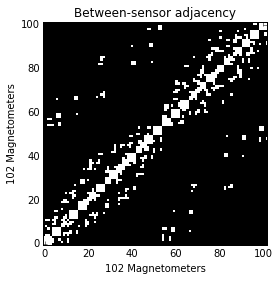

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt  # and we can visualize it.

plt.imshow(connectivity.toarray(), cmap='gray', origin='lower',
           interpolation='nearest')
plt.xlabel('{} Magnetometers'.format(len(ch_names)))
plt.ylabel('{} Magnetometers'.format(len(ch_names)))
plt.title('Between-sensor adjacency');

# Compute spatiotemporal clustering statistic

In [5]:
# choose statistic used to form clusters
stat_fun = mne.stats.parametric.f_oneway

# set cluster formation threshold
threshold = 50.0  # very high, but the test is quite sensitive on this data

# set family-wise p-value (let's be conservative today)
p_accept = 0.001

# don't forget, destpite the F-test we chose as cluster statistic this remains
# a non-parametric test
cluster_stats = spatio_temporal_cluster_test(X, n_permutations=1024,
                                             threshold=threshold, tail=1,
                                             stat_fun=stat_fun,
                                             connectivity=connectivity,
                                             n_jobs=2)

How does it work? We use clustering to `bind` together features which are
similar. Our features are the magnetic fields measured over our sensor
array at different times. This reduces the multiple comparison problem.
To compute the actual test-statistic, we first sum all F-values in all
clusters. We end up with one statistic for each cluster.
Then we genereate a distribution from the data by shuffling our conditions
between our samples and recomputing our clusters and the test statistics.
We test for the signficance of a given cluster by computing the probability
of observing a cluster of that size. For more background read:

    Maris/Oostenveld (2007), "Nonparametric statistical testing of EEG- and
    MEG-data" Journal of Neuroscience Methods, Vol. 164, No. 1., pp. 177-190.
    doi:10.1016/j.jneumeth.2007.03.024


In [6]:
T_obs, clusters, p_values, _ = cluster_stats

In [7]:
# only keep good clusters
good_cluster_inds = np.where(p_values < p_accept)[0]
print(good_cluster_inds)

[0 1 2 3 4 5 6 7]


In [8]:
T_obs.shape

(106, 102)

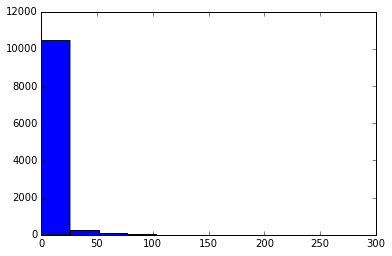

In [9]:
plt.hist(T_obs.ravel());

In [10]:
mne.EvokedArray?

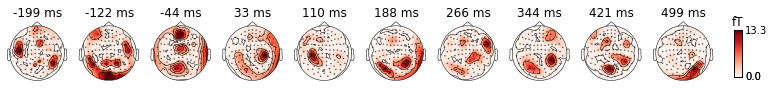

In [11]:
evoked = mne.EvokedArray(T_obs.T, epochs.info, tmin=epochs.tmin)
evoked.plot_topomap(scale=1.);

Note. The same functions works with source estimate. The only differences
are the origin of the data, the size, and the connectivity definition.
It can be used for single trials or for groups of subjects.

# Visualize clusters

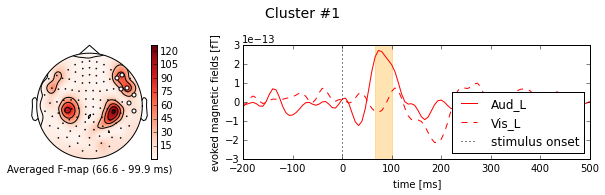

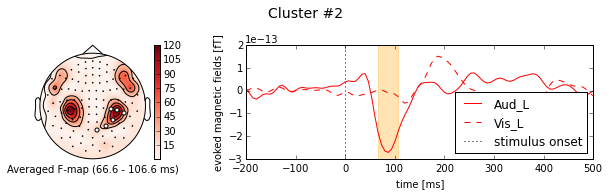

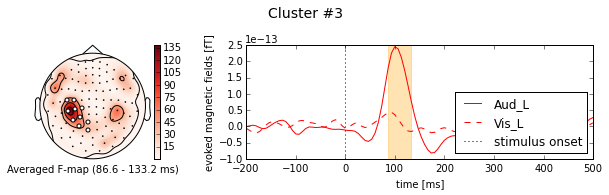

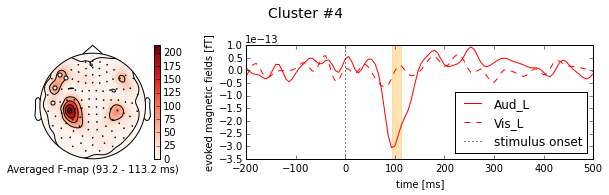

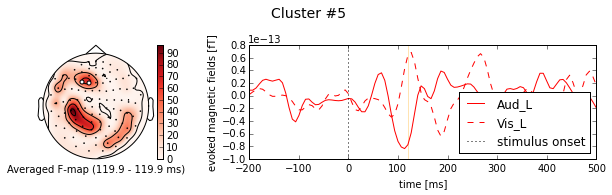

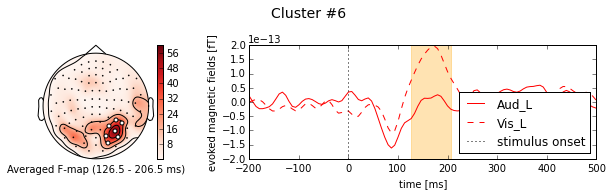

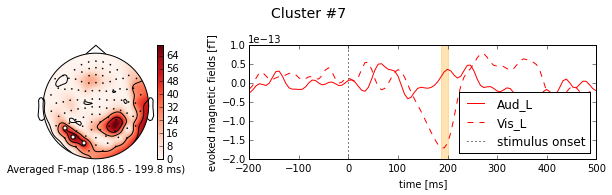

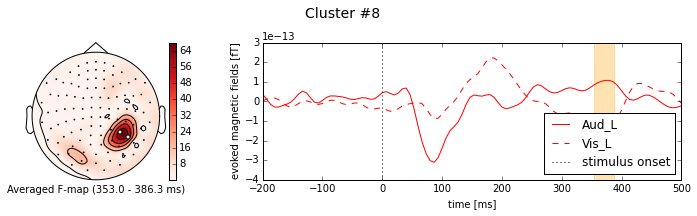

In [12]:
%matplotlib inline

# load additional viz functionality
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.viz import plot_topomap

# configure variables for visualization
times = epochs.times * 1e3

# 4 conditions, 4 colors, 4 lines styles
colors = 'r', 'r'#, 'steelblue', 'steelblue'
linestyles = '-', '--' #, '-', '--'

# grand average as numpy arrray
grand_ave = np.array(X).mean(axis=1)

# get sensor positions via layout
pos = mne.find_layout(epochs.info).pos

# loop over significant clusters
for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpack cluster infomation, get unique indices
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)

    # get topography for F stat
    f_map = T_obs[time_inds, ...].mean(axis=0)

    # get signals at significant sensors
    signals = grand_ave[..., ch_inds].mean(axis=-1)
    sig_times = times[time_inds]

    # create spatial mask
    # initialize array of bools (False)
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True  # set to True at ch_inds

    # initialize figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))
    title = 'Cluster #{0}'.format(i_clu + 1)
    fig.suptitle(title, fontsize=14)

    # plot average test statistic and mark significant sensors
    image, _ = plot_topomap(f_map, pos, mask=mask, axis=ax_topo,
                            cmap='Reds', vmin=np.min, vmax=np.max,
                            show=False)

    # advanced matplotlib for showing image with figure and colorbar
    # in one plot
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel('Averaged F-map ({:0.1f} - {:0.1f} ms)'.format(
        *sig_times[[0, -1]]  # Quiz: what does the astersik do here?
    ))

    # add new axis for time courses and plot time courses
    ax_signals = divider.append_axes('right', size='300%', pad=1.2)
    for signal, name, col, ls in zip(signals, condition_names, colors,
                                     linestyles):
        ax_signals.plot(times, signal, color=col, linestyle=ls, label=name)

    # add some information to axes
    ax_signals.axvline(0, color='k', linestyle=':', label='stimulus onset')
    ax_signals.set_xlim([times[0], times[-1]])
    ax_signals.set_xlabel('time [ms]')
    ax_signals.set_ylabel('evoked magnetic fields [fT]')

    # plot significant time range
    ymin, ymax = ax_signals.get_ylim()
    ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                             color='orange', alpha=0.3)
    # add a legend
    ax_signals.legend(loc='lower right')
    ax_signals.set_ylim(ymin, ymax)

# clean up viz
mne.viz.tight_layout(fig=fig)
fig.subplots_adjust(bottom=.05)
plt.show()

# Excercises

- What is the smallest p-value you can obtain, given the finite number of permutations?
- Use an F distribution to compute the threshold by tradition significance levels. Hint: take a look at ```scipy.stats.distributions.f```
- Visualize the difference between the auditory and the visual evoked instead of using the F-map
- Discover and use the TFCE option